[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aim-lab/PVBM/blob/main/pvbmtutorial.ipynb)

# PVBM Tutorial

If you are using colab, install the pvbm library by uncommenting the following cell

In [37]:
#pip install pvbm --upgrade

## Import the libraries

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from PIL import Image,ImageFilter #Import Pillow library to load the images
import numpy as np #Import numpy
import matplotlib.pyplot as plt #Import matplotlib library for visualization
from skimage.morphology import skeletonize,square,dilation #Import functions to compute morphological operations

## Download the example images

In [40]:
image1 = "117-793-749-000036_RR_43001_04734_F_48.png"
# image1 = '../MorphoSnake/img/2.png'
image2 = "121-691-760-V721942_RR_63739_04251_M_74.png"

In [41]:
import os

os.system('wget -P images https://raw.githubusercontent.com/aim-lab/PVBM/main/images/{} > /dev/null 2>&1'.format(image1))
os.system('wget -P images https://raw.githubusercontent.com/aim-lab/PVBM/main/images/{} > /dev/null 2>&1'.format(image2))
print("Images downloaded successfully")

Images downloaded successfully


## Load an image

In [42]:
segmentation_path = "images/"+image1 #replace image1 by image2 if you want to use the second example
# segmentation_path = image1

In [43]:
segmentation_src = Image.open(segmentation_path) #Open the segmentation

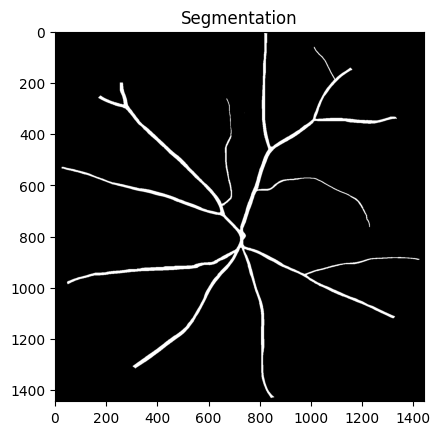

In [44]:
plt.imshow(segmentation_src,cmap = "gray") #Display the segmentation
plt.title("Segmentation")
plt.show()

In [45]:
# Depending on the quality of the segmentation, you would need to regularize (smooth) it more or less 
#before computing the skeleton for instance by uncomment the following command
#segmentation = segmentation.filter(ImageFilter.ModeFilter(size=3))

def get_skeleton():
    import cv2
    import skimage.io as io
    image = io.imread(segmentation_path)
    print(image.shape,np.max(image))
    image = np.where(image>128,255,0).astype(np.uint8)
    print(image.dtype,np.max(image))
    # # 骨架化
    # skeleton = morphology.skeletonize(image)

    # # 保存结果
    # io.imsave('retina_vessel_skeleton.png', skeleton)


    A = 200
    L = 50

    # Centerline extraction using Zeun-Shang's thinning algorithm
    # Using opencv-contrib-python which provides very fast and efficient thinning algorithm
    # The package can be installed using pip
    thinned = cv2.ximgproc.thinning(image)
    # Filling broken lines via morphological closing using a linear kernel
    kernel = np.ones((1, 10), np.uint8)
    d_im = cv2.dilate(thinned, kernel)
    e_im = cv2.erode(d_im, kernel) 
    num_rows, num_cols = thinned.shape
    for i in range (1, 360//15):
        rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 15*i, 1)
        img_rotation = cv2.warpAffine(thinned, rotation_matrix, (num_cols, num_rows))
        temp_d_im = cv2.dilate(img_rotation, kernel)
        temp_e_im = cv2.erode(temp_d_im, kernel) 
        rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), -15*i, 1)
        im = cv2.warpAffine(temp_e_im, rotation_matrix, (num_cols, num_rows))
        e_im = np.maximum(im, e_im)
    # Skeletonizing again to remove unwanted noise
    thinned1 = cv2.ximgproc.thinning(e_im)
    # thinned1 = thinned1*(mask/255)
    # Removing bifurcation points by using specially designed kernels
    # Can be optimized further! (not the best implementation)
    thinned1 = np.uint8(thinned1)



    thh = thinned1.copy()
    hi = thinned1.copy()
    thi = thinned1.copy()
    hi = cv2.cvtColor(hi, cv2.COLOR_GRAY2BGR)
    thi = cv2.cvtColor(thi, cv2.COLOR_GRAY2BGR)
    thh = thh/255
    kernel1 = np.array([[1,0,1],[0,1,0],[0,1,0]])
    kernel2 = np.array([[0,1,0],[1,1,1],[0,0,0]])
    kernel3 = np.array([[0,1,0],[0,1,1],[1,0,0]])
    kernel4 = np.array([[1,0,1],[0,1,0],[0,0,1]])
    kernel5 = np.array([[1,0,1],[0,1,0],[1,0,1]])
    kernels = [kernel1, kernel2, kernel3, kernel4, kernel5]
    for k in kernels:
        k1 = k
        k2 = cv2.rotate(k1, cv2.ROTATE_90_CLOCKWISE)
        k3 = cv2.rotate(k2, cv2.ROTATE_90_CLOCKWISE)
        k4 = cv2.rotate(k3, cv2.ROTATE_90_CLOCKWISE)
        ks = [k1, k2, k3, k4]
        for kernel in ks:
            th = cv2.filter2D(thh, -1, kernel)
            for i in range(th.shape[0]):
                for j in range(th.shape[1]):
                    if(th[i,j]==4.0):
                        cv2.circle(hi, (j, i), 2, (0, 255, 0), 2)
                        cv2.circle(thi, (j, i), 2, (0, 0, 0), 2)
    thi = cv2.cvtColor(thi, cv2.COLOR_BGR2GRAY)
    cl = thi.copy()
    contours, hierarchy = cv2.findContours(thi, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        if (c.size<L):
            cv2.drawContours(cl, [c], 0, 0, -1)


    # # Centerline superimposed on green channel
    # colors = [(100, 0, 150), (102, 0, 255), (0, 128, 255), (255, 255, 0), (10, 200, 10)]
    # colbgr = [(193, 182, 255), (255, 0, 102), (255, 128, 0), (0, 255, 255), (10, 200, 10)]
    # im = g.copy()
    # im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
    # thc = cl
    # thh = thc.copy()
    # thh = cv2.cvtColor(thh, cv2.COLOR_GRAY2BGR)
    # contours, heirarchy = cv2.findContours(thc, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # for c in contours:
        
    #         color = np.random.randint(len(colors))
    #         cv2.drawContours(im, c, -1, colbgr[color], 2, cv2.LINE_AA)

    cv2.imwrite('00.png',thinned1)
    # cv2.imshow('closed contour', thinned1)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    ## d = mv*1.5

    return thinned1

# segmentation = np.array(segmentation_src)/255 #Convert the segmentation to a numpy array with value 0 and 1
# skeleton = skeletonize(segmentation) # Compute the skeleton of the segmentation

# segmentation = (np.array(segmentation)*255).astype(np.uint8)[:,:,0]
# print(segmentation.shape,np.max(segmentation),segmentation.dtype)
skeleton = get_skeleton()>128 # Compute the skeleton of the segmentation
# print(np.max(skeleton),skeleton.shape)

(1444, 1444) 255
uint8 255


In [46]:
print(np.min(skeleton))

False


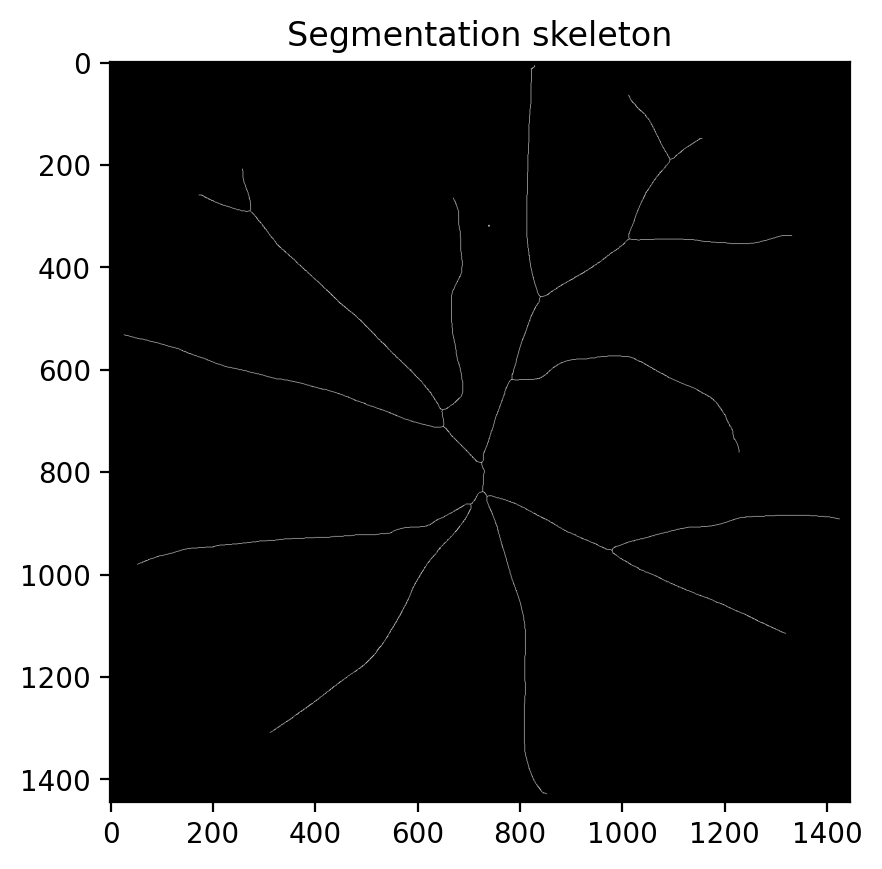

In [47]:
plt.figure(dpi=200)
plt.imshow(skeleton,cmap = 'gray')
plt.title("Segmentation skeleton")
plt.show()

## Compute the area

In [48]:
from PVBM.GeometricalAnalysis import GeometricalVBMs #Import the geometrical analysis module
geometricalVBMs = GeometricalVBMs() #Instanciate a geometrical VBM object

In [49]:
a = geometricalVBMs.area(skeleton)
print("The area is {}".format(a))

The area is 7567


## Compute the endpoints and intersection points

In [50]:
n_end,n_inter,end,inter = geometricalVBMs.compute_particular_points(skeleton)
# print(type(end),end.shape)
print("There is {} endpoints and {} intersection points".format(n_end,n_inter))

There is 15 endpoints and 18 intersection points


In [51]:
#Dilation of the endpoints and intersection points for vizualisation
segmentation = np.array(segmentation_src)/255
end_dilated = dilation(end, square(5))
print(np.max(end_dilated))
inter_dilated = dilation(inter, square(5))

True


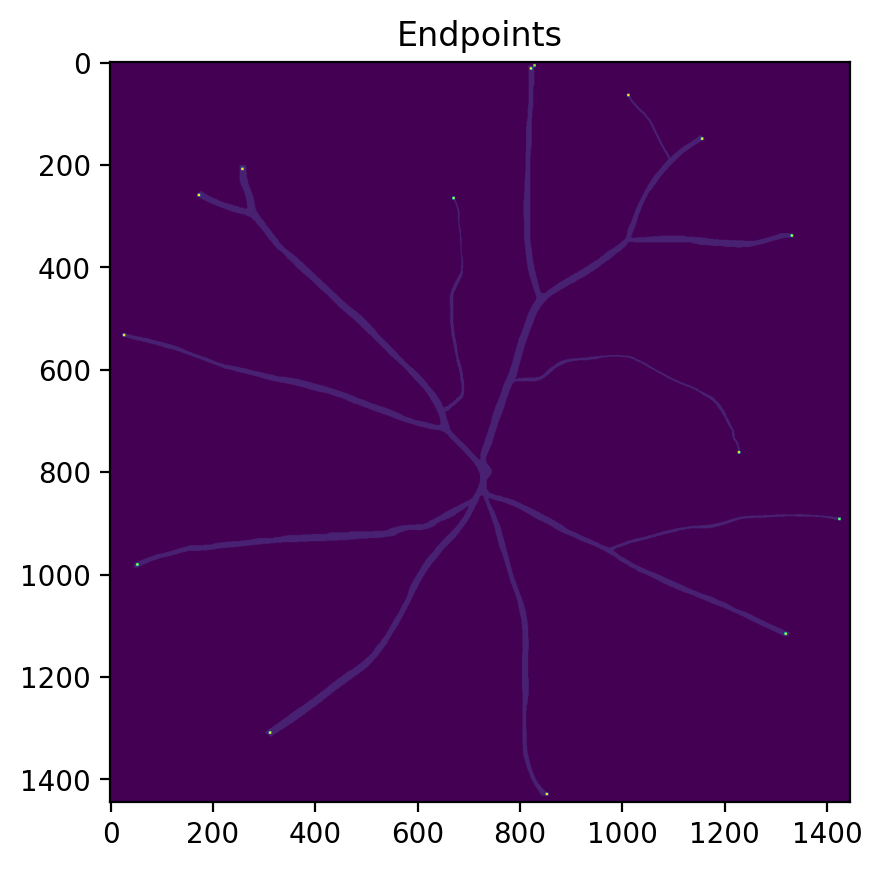

In [52]:
plt.figure(dpi=200)
plt.imshow(segmentation/10+end_dilated)
plt.title('Endpoints')
plt.show()


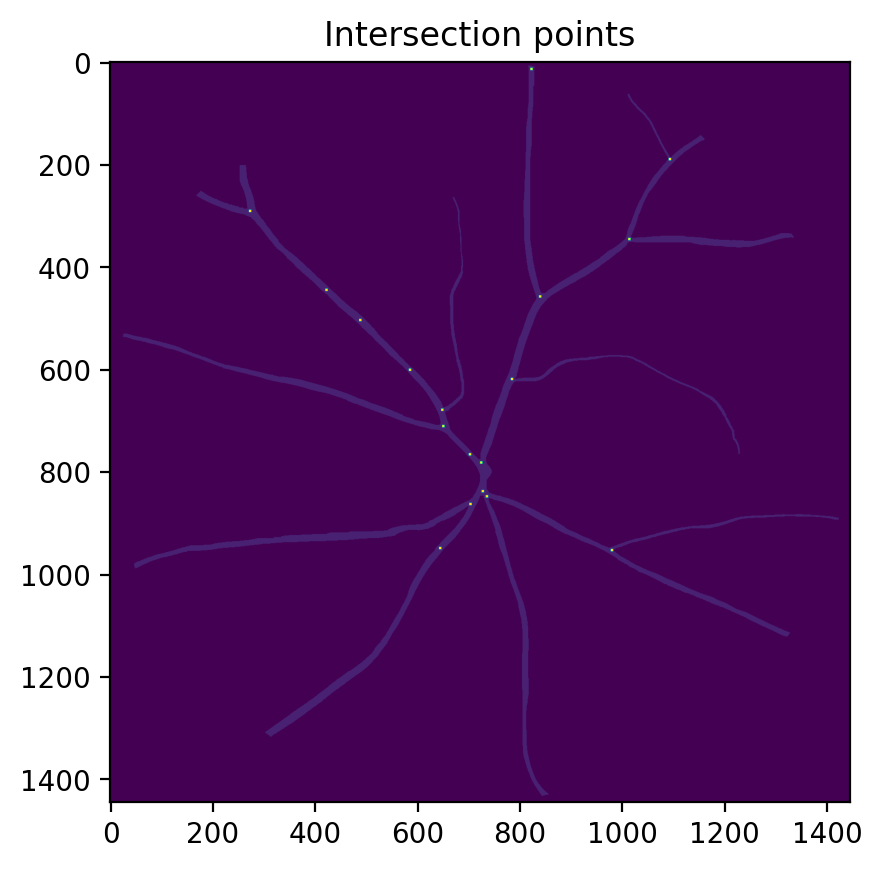

In [53]:
plt.figure(dpi=200)
plt.imshow(segmentation/10+inter_dilated)
plt.title("Intersection points")
plt.show()


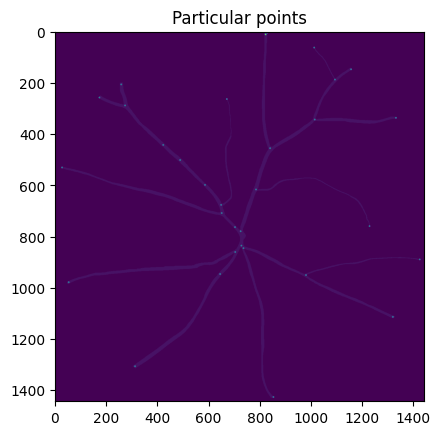

In [54]:
plt.imshow(segmentation/10+inter_dilated+end_dilated)
plt.title("Particular points")
plt.show()

## Compute the tortuosity and the length

In [55]:
median_tor, length,chord,arc,connection_dico = geometricalVBMs.compute_tortuosity_length(skeleton) #times depends in the resolution of the segmentation (smaller is faster)

In [56]:
print("The median tortuosity is {}".format(median_tor))

The median tortuosity is 1.0775933558124562


In [57]:
print("Here is the list containing the arc length of every blood vessels (between two particular points) {}."
      .format(arc[:3]))

Here is the list containing the arc length of every blood vessels (between two particular points) [367.3847763108503, 10.071067811865476, 12.071067811865476].


In [58]:
print("Here is the list containing the chord length of every blood vessels (between two particular points) {}."
      .format(chord[:3]))

Here is the list containing the chord length of every blood vessels (between two particular points) [362.03452874000845, 9.433981132056603, 11.180339887498949].


In [59]:
print("We can recompute the median tortuosity:{} and we can compute the tortuosity index: {}."
      .format(np.median(np.array(arc)/np.array(chord)), np.sum(arc)/np.sum(chord)))

We can recompute the median tortuosity:1.0775933558124562 and we can compute the tortuosity index: 1.054157926452497.


In [60]:
print("The length is {}".format(length))

The length is 4538.347843179529


2495


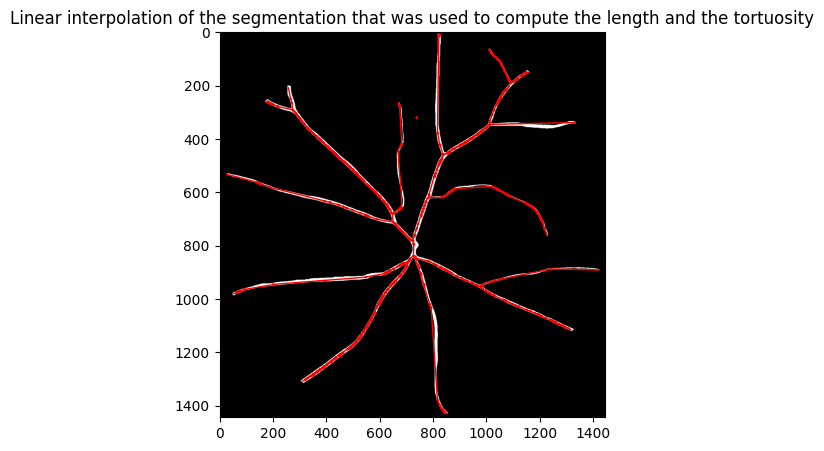

In [61]:
fig = plt.figure(figsize=(5,5))
print(len(connection_dico))
for key,values in connection_dico.items():
    x1,y1 = key
    for value in values:
        x2,y2 = value[0][0],value[0][1]
        x_ = (x1,x2)
        y_ = (y1,y2)
        plt.plot(y_,x_, color="red", linewidth=1)
plt.imshow(segmentation,cmap = 'gray')
plt.title('Linear interpolation of the segmentation that was used to compute the length and the tortuosity')
plt.show()

## Compute the perimeter

In [62]:
p,border_matrix = geometricalVBMs.compute_perimeter(segmentation) #times depends in the resolution of the segmentation (smaller is faster)

In [63]:
print("The perimeter is {}".format(p))

The perimeter is 15346.989601378666


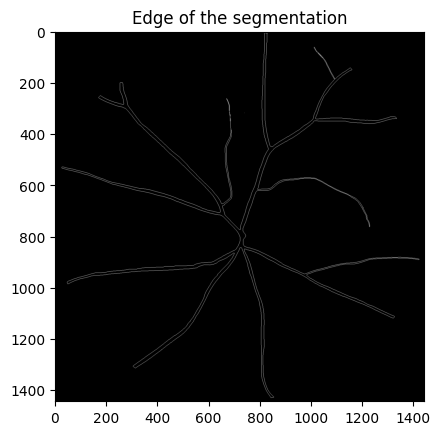

In [64]:
plt.imshow(border_matrix,cmap = "gray")
plt.title("Edge of the segmentation")
plt.show()

## Branching angles

In [65]:
mean_ba,std_ba,median_ba,angle_dico,centroid = geometricalVBMs.compute_branching_angles(skeleton)

In [66]:
mean_ba,std_ba,median_ba
print("The mean, std and median branching angles are mean: {}, std: {}, median: {}".format(mean_ba,std_ba,median_ba))

The mean, std and median branching angles are mean: 92.31733759595707, std: 55.510558194937786, median: 90.89985971490441


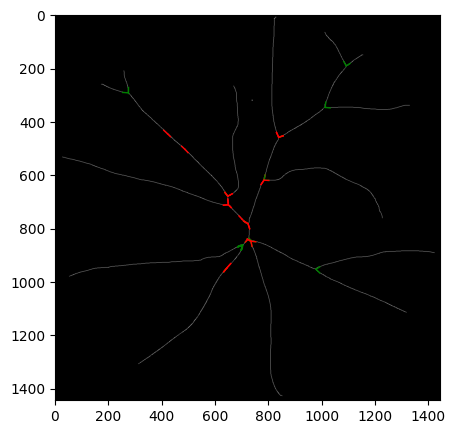

In [67]:
fig = plt.figure(figsize=(5,5))
for points,angle in angle_dico.items():
    b,a,c = points
    if True:
        if angle > 90 :
            x_ = [b[0],a[0]]
            y_ = [b[1],a[1]]
            plt.plot(y_,x_, color="red", linewidth=1)
            x_ = [b[0],c[0]]
            y_ = [b[1],c[1]]
            plt.plot(y_,x_, color="red", linewidth=1)
        if angle < 90 :
            x_ = [b[0],a[0]]
            y_ = [b[1],a[1]]
            plt.plot(y_,x_, color="green", linewidth=1)
            x_ = [b[0],c[0]]
            y_ = [b[1],c[1]]
            plt.plot(y_,x_, color="green", linewidth=1)
plt.imshow(skeleton,cmap = 'gray')
plt.show()

The centroid can also be ploted (independent for each subgraph)

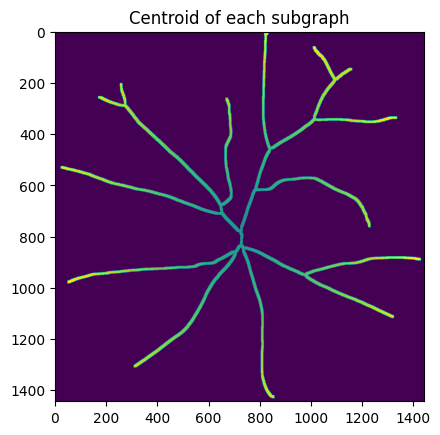

In [68]:
plt.imshow(dilation(centroid,square(10)))
plt.title("Centroid of each subgraph")
plt.show()

Lets extract each subgraph and their centroid

In [69]:
graphs = 1*(centroid != -1)

In [70]:
from queue import PriorityQueue
def iterative(A, B, i, j, n):
  pq = PriorityQueue()
  pq.put((0,A,B,i,j,n))
  priotities = [0,1,2,3,4,5,6,7]
  while not pq.empty():
    _,A, B, i, j, n = pq.get()
    directions = [(i-1,j),(i+1,j),(i,j-1),(i,j+1),(i-1,j-1),(i-1,j+1),(i+1,j-1),(i+1,j+1)]
    for direction,priority in zip(directions,priotities):
      x,y = direction
      if x >= 0 and x < A.shape[0] and y >= 0 and y < A.shape[1] and A[direction] == 1:
            B[direction] = n
            A[direction] = 0
            pq.put((priority,A,B,direction[0],direction[1],n))


In [71]:
from tqdm.notebook import tqdm
def extract_subgraphs(graphs):
    B = np.zeros_like(graphs)
    n = 1
    for i in tqdm(range(graphs.shape[0])):
        for j in range(graphs.shape[1]):
            if B[i,j] == 0 and graphs[i,j] == 1:
                iterative(graphs,B,i,j,n)
                n+=1
    return B
    
    

In [72]:
B = extract_subgraphs(graphs.copy())

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

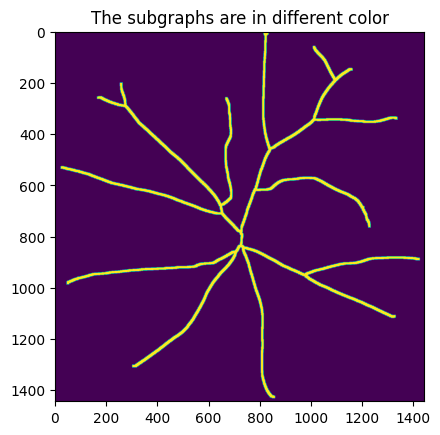

In [ ]:
plt.imshow(dilation(B*100,square(10)))
plt.title("The subgraphs are in different color")
plt.show()

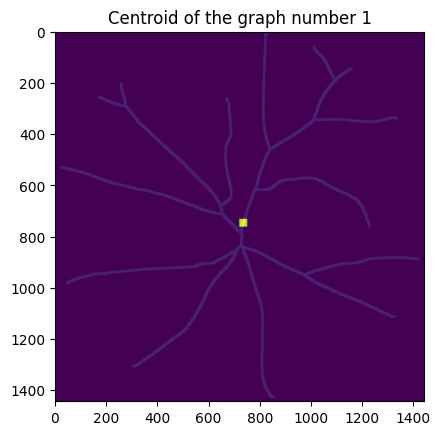

In [ ]:
for i in range(1,B.max()+1):
    mask = B == i
    sub_skeleton = skeleton * mask
    sub_centroid = centroid * mask
    sub_centroid_tmp = sub_centroid.copy()
    sub_centroid_tmp[sub_centroid_tmp == 0 ] = np.inf
    detected_centroid = sub_centroid_tmp == sub_centroid_tmp.min()
    plt.imshow(dilation(sub_skeleton,square(10)) + 10*dilation(detected_centroid,square(30)))
    plt.title("Centroid of the graph number {}".format(i))
    plt.show()
    

## Fractal Analysis

In [ ]:
from PVBM.FractalAnalysis import MultifractalVBMs
fractalVBMs = MultifractalVBMs(n_rotations = 25,optimize = True, min_proba = 0.0001, maxproba = 0.9999)

In [ ]:
D0,D1,D2,SL = fractalVBMs.compute_multifractals(segmentation)

In [ ]:
print("The fractal biomarkers are D0: {}, D1: {}, D2: {}, SL: {}".format(D0,D1,D2,SL))

The fractal biomarkers are D0: 1.3108560242559306, D1: 1.2990298019085615, D2: 1.2969899646342158, SL: 0.7232841382079696
